# STAT 542 / CS 598: Homework 3

Fall 2019, by Edgar Pino

Due: Monday, Oct 7 by 11:59 PM Pacific Time

# Question 1 [50 Points] A Simulation Study


In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from basis_expansions import NaturalCubicSpline
from scipy.interpolate import UnivariateSpline

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
numpy2ri.activate()

## Training data n=30: Generate x from [−1,1] uniformly, and then generate y=sin(πx)+ϵ, where ϵ’s are iid standard normal

In [9]:
def gen_train_data(n=30):
    x_train = np.random.uniform(-1,1,n)
    epsilon = np.random.randn(n)
    y_train = np.sin((x_train * np.pi)) + epsilon
    return x_train, y_train

In [20]:
test_x = np.linspace(-1, 1, num=100)

In [38]:
x, y = gen_train_data()

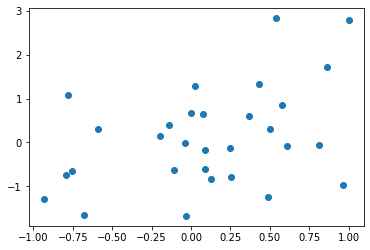

In [39]:
plt.plot(x, y, 'o')
plt.show()

## Write your own code (you cannot use bs() or similar functions) to implement a continuous piecewise linear spline fitting. Choose knots at 

In [12]:
class ContinuousPiecewiseLinearSpline(BaseEstimator, TransformerMixin):
    def __init__(self, knots=None):
        self.knots = np.asarray(knots)
        
    def fit(self, *args, **kwargs):
        return self
    
    def transform(self, x):
        n_knots = len(self.knots)
        knots = np.asarray(self.knots)
        ls = np.zeros((x.shape[0], n_knots + 1))
        ls[:, 0] = x.squeeze()

        for i, knot in enumerate(knots, start=1):
            ls[:, i] = np.maximum(0, x - knot).squeeze()
        
        return ls

In [13]:
def my_spline_reg(knots):
    return Pipeline([
        ('splnes', ContinuousPiecewiseLinearSpline(knots=knots)),
        ('regression', LinearRegression())
    ])

In [16]:
linear_model = my_spline_reg([-0.5,0,0.5])

In [40]:
linear_model.fit(x.reshape(-1,1), y)

Pipeline(memory=None,
         steps=[('splnes',
                 ContinuousPiecewiseLinearSpline(knots=array([-0.5,  0. ,  0.5]))),
                ('regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

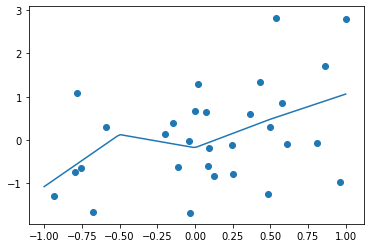

In [41]:
plt.plot(test_x, linear_model.predict(test_x.reshape(-1,1)))
plt.scatter(x,y)
plt.show()

## Use existing functions to implement a quadratic spline 2 knots. Choose your own knots.

In [22]:
from scipy.interpolate import interp1d

In [23]:
def quadratic_spline(x, y):
    return interp1d(x, y, kind='quadratic', fill_value="extrapolate")

In [42]:
quadratic_model = quadratic_spline(x,y)

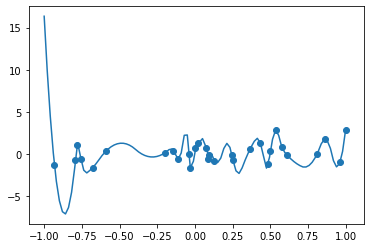

In [43]:
plt.plot(test_x, quadratic_model(test_x.reshape(-1,1)))
plt.scatter(x,y)
plt.show()

## Use existing functions to implement a natural cubic spline with 3 knots. Choose your own knots.

In [44]:
def my_cubic_reg(knots):
    return Pipeline([
        ('cubic', NaturalCubicSpline(knots=knots)),
        ('regression', LinearRegression())
    ])

In [45]:
cubic_model = my_cubic_reg(knots=[-0.5,0.5,1])

In [46]:
cubic_model.fit(x.reshape(-1,1), y)

Pipeline(memory=None,
         steps=[('cubic',
                 NaturalCubicSpline(knots=array([-0.5,  0.5,  1. ]), max=None,
                                    min=None, n_knots=3, n_params=2)),
                ('regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

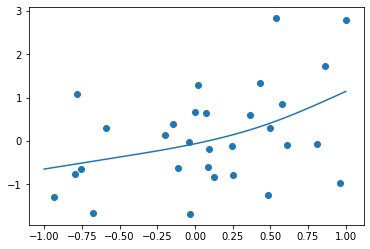

In [47]:
plt.plot(test_x, cubic_model.predict(test_x.reshape(-1,1)))
plt.scatter(x,y)
plt.show()

## Use existing functions to implement a smoothing spline. Use the built-in ordinary leave-one-out cross-validation to select the best tuning parameter.


In [101]:
def smooth_spline(x, y, **args):
    smooth_spline = robjects.r['smooth.spline']
    return smooth_spline(x, y, **args)

In [102]:
r_predict = robjects.r['predict']

In [103]:
results = smooth_spline(x, y, cv=True, df=5)

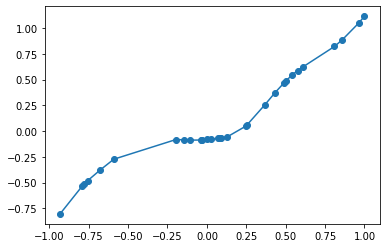

In [104]:
plt.plot(results[0], results[1], 'o-')
plt.show()

## After fitting these models, evaluate their performances by comparing the fitted functions with the true function value on an equispaced grid of 1000 points on [−1,1]. Use the squared distance as the metric. Repeat the entire process 200 times. Record and report the mean, median, and standard deviation of the errors for each method. Also, provide an informative boxplot that displays the error distribution for all models side-by-side.


In [107]:
def get_squared_distance(y_true, y_pred):
    return np.sum(np.square(y_true - y_pred))

In [151]:
linear_errors = []
quadratic_errors = []
cubic_errors = []
smooth_errors = []

x_test = np.linspace(-1, 1, num=1000)
y_test = np.sin(np.pi*x_test)
for i in range(200):
    x_train, y_train = gen_train_data()
    
    t_linear_model = my_spline_reg([-0.5,0,0.5]).fit(x_train.reshape(-1,1), y_train)
    t_quadratic_model = quadratic_spline(x_train,y_train)
    t_cubic_model = my_cubic_reg(knots=[-0.5,0.5,1]).fit(x_train.reshape(-1,1), y_train)
    t_smooth_model = smooth_spline(x_train, y_train, cv=True)
    
    y_linear_pred = t_linear_model.predict(x_test)
    y_quadratic_pred = t_quadratic_model(x_test)
    y_cubic_pred = t_cubic_model.predict(x_test)
    y_smooth_pred = r_predict(t_smooth_model, x_test)[1]
    
    linear_errors.append(get_squared_distance(y_test, y_linear_pred))
    quadratic_errors.append(get_squared_distance(y_test, y_quadratic_pred))
    cubic_errors.append(get_squared_distance(y_test, y_cubic_pred))
    smooth_errors.append(get_squared_distance(y_test, y_smooth_pred))

R[write to console]: spar-finding: non-finite value inf; using BIG value



In [172]:
errors = pd.DataFrame()

In [173]:
errors['linear_errors'] = linear_errors
errors['cubic_errors'] = cubic_errors
errors['smooth_errors'] = smooth_errors

In [174]:
mean = errors.mean()

In [175]:
median = errors.median()

In [176]:
std = errors.std()

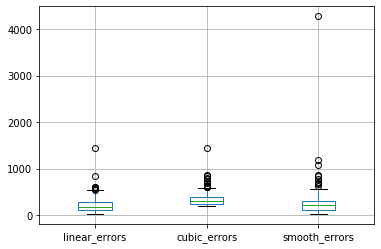

In [177]:
errors.boxplot()
plt.show()

### With Quadratic errors

In [178]:
errors['quadratic_errors'] = quadratic_errors

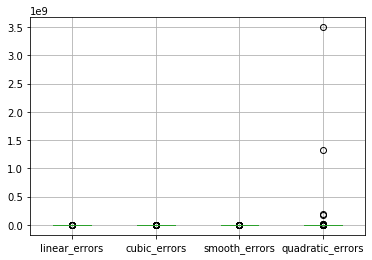

In [179]:
errors.boxplot()
plt.show()

## Comment on your findings. Which method would you prefer?

I would prefer then continuous piecewise linear model or the smoothing spline model based on the charts. 

# Question 2 [50 Points] Multi-dimensional Kernel and Bandwidth Selection

In [180]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from mcmodels.regressors import NadarayaWatson
from sklearn import preprocessing

In [205]:
np.random.seed(1)

In [181]:
ccpp_data = pd.read_csv('CCPP.csv')

In [182]:
ccpp_data = ccpp_data.apply(pd.to_numeric, errors='coerce').dropna()

In [183]:
mm_scaler = preprocessing.MinMaxScaler()
ccpp_data = pd.DataFrame(mm_scaler.fit_transform(ccpp_data), columns=ccpp_data.columns)

In [184]:
ccpp_y = pd.DataFrame(ccpp_data.PE, columns=['PE']).to_numpy()

In [185]:
ccpp_x = ccpp_data.drop(['PE'], axis=1).to_numpy()

## Randomly select 2/3 of the data as training data, and rest as testing. Make sure you set a random seed. You do not need to repeat this process — just fix it and complete the rest of the questions

In [186]:
X_train, X_test, y_train, y_test = train_test_split(ccpp_x, ccpp_y, train_size=2/3, random_state=1)

In [187]:
print(f"{len(X_train)} in train and {len(X_test)} in test")
assert (len(X_train) + len(X_test)) == len(ccpp_data)

31893 in train and 15947 in test


## Fit the model on the training samples using the kernel estimator and predict on the testing sample. Calculate the prediction error and compare this to a linear model

In [188]:
def mean_square_error(y_true, y_pred):
    return np.square(np.subtract(y_true,y_pred)).mean()

#### Fit on kernel estimator

In [189]:
nw = NadarayaWatson()

In [190]:
nw.fit(X_train, y_train)

NadarayaWatson(coef0=1, degree=3, gamma=None, kernel='linear',
               kernel_params=None)

In [191]:
y_pred_nw = nw.predict(X_test)

In [192]:
nw_mse = mean_square_error(y_test, y_pred_nw)

In [193]:
print(f"Kernal estimator MSE {nw_mse}")

Kernal estimator MSE 0.04463322689384729


#### Fit on linear model

In [194]:
linear_reg = LinearRegression().fit(X_train, y_train)

In [195]:
y_pred_lm = linear_reg.predict(X_test)

In [196]:
lm_mse = mean_square_error(y_test, y_pred_lm)

In [197]:
print(f"Linear model estimator MSE {lm_mse}")

Linear model estimator MSE 0.0036381204562529815


## The bandwidth selection may not be optimal in practice. Experiment a few choices and see if you can achieve a better result.

In [198]:
from sklearn.model_selection import GridSearchCV

In [199]:
param_grid=dict(kernel=["rbf"], gamma=np.logspace(-2, 2, 25))
nw_gs = GridSearchCV(NadarayaWatson(), cv=5, param_grid=param_grid)

In [200]:
nw_gs = nw_gs.fit(X_train, y_train)

In [201]:
y_gs = nw_gs.predict(X_test)

In [202]:
gs_mse = mean_square_error(y_test, y_gs)

In [203]:
print(f"best bandwidth found: {nw_gs.best_estimator_.gamma} with MSE of: {gs_mse}")

best bandwidth found: 100.0 with MSE of: 0.003194717367384368


In [204]:
print(f"Linear Model MSE: {lm_mse}.\nBest bandwidth MSE: {gs_mse}")

Linear Model MSE: 0.0036381204562529815.
Best bandwidth MSE: 0.003194717367384368
